In [85]:
# Import modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import optuna
import numpy as np

In [86]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f'Using device: {device}')
        print(f'GPU: {torch.cuda.get_device_name(0)}')
    else:
        print(f'Using device: {device}')

    return device

In [87]:
def norm_data(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }

    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    # Get the unique experiment numbers in order
    exp_num_list = sorted(ndf['exp'].unique())
    return ndf, exp_num_list

In [88]:
def seq_data(ndf):
    seq = []
    # Ï†ÑÎ•ò(I)Îäî Ìè¨Ìï®: ground truthÎ°ú ÏÇ¨Ïö©ÌïòÏó¨ ÏòàÏ∏° ÏÑ±Îä• ÎπÑÍµê
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        seq.append(exp_data[feature_cols].values)
    
    return seq

In [89]:
def pad_seq(seq):
    max_len = max([len(seq) for seq in seq])
    seq_len = [len(seq) for seq in seq]
    pad_seq = pad_sequence([torch.tensor(seq) for seq in seq], batch_first=True, padding_value=-1)

    return pad_seq, seq_len, max_len

In [90]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [91]:
def dataloaders(dataset, exp_num_list, batch_size=4):
    """
    Split the dataset into train/val/test with 8:1:1 ratio
    
    Args:
        dataset: TensorDataset
        exp_num_list: list of experiment numbers
        batch_size: batch size
        random_state: random seed
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """

    
    # required train experiment numbers
    required_train_exps = [0, 5, 8, 10, 15, 17, 20, 21, 22, 23, 30]
    
    # all experiment numbers
    all_exps = exp_num_list
    total_exps = len(all_exps)
    
    # batch_size
    batch_size = math.ceil(len(dataset)/10)

    # 8:1:1 ratio
    train_count = int(total_exps * 0.8)
    val_count = math.ceil(total_exps * 0.1)
    
    # remaining experiments
    remaining_exps = [exp for exp in all_exps if exp not in required_train_exps]
    
    # number of experiments to add to train
    additional_train_needed = train_count - len(required_train_exps)
    
    if additional_train_needed < 0:
        raise ValueError("The number of required train experiments is greater than the total train set. Please adjust required_train_exps.")
    
    # shuffle remaining experiments
    np.random.shuffle(remaining_exps)
    
    # split remaining experiments into train, val, test
    train_exps = required_train_exps + remaining_exps[:additional_train_needed]
    val_exps = remaining_exps[additional_train_needed:additional_train_needed + val_count]
    test_exps = remaining_exps[additional_train_needed + val_count:]
    
    print(f"Actual split:")
    print(f"  Train: {sorted(train_exps)} ({len(train_exps)} experiments)")
    print(f"  Val: {sorted(val_exps)} ({len(val_exps)} experiments)")  
    print(f"  Test: {sorted(test_exps)} ({len(test_exps)} experiments)")
    
    # find indices of each experiment (exp_num_list and dataset have the same order)
    train_indices = []
    val_indices = []
    test_indices = []
    
    for idx, exp in enumerate(all_exps):
        if exp in train_exps:
            train_indices.append(idx)
        elif exp in val_exps:
            val_indices.append(idx)
        elif exp in test_exps:
            test_indices.append(idx)
    
    # split dataset into train, val, test
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    # create DataLoader
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    print(f"\nCompleted DataLoader creation:")
    print(f"  Train: {len(train_subset) if train_subset else 0} sequences")
    print(f"  Val: {len(val_subset) if val_subset else 0} sequences")
    print(f"  Test: {len(test_subset) if test_subset else 0} sequences")
    
    return train_loader, val_loader, test_loader

In [92]:
class LayerNormLSTMCell(nn.Module):
    """LSTM Cell with Layer Normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node
        
        # Input-to-hidden and hidden-to-hidden transformations
        self.weight_ih = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.weight_hh = nn.Linear(hidden_node, 4 * hidden_node, bias=False)
        
        # Layer normalization for each gate
        self.ln_i = nn.LayerNorm(hidden_node)  # Input gate
        self.ln_f = nn.LayerNorm(hidden_node)  # Forget gate  
        self.ln_g = nn.LayerNorm(hidden_node)  # Cell gate
        self.ln_o = nn.LayerNorm(hidden_node)  # Output gate
        
        # Cell state layer norm
        self.ln_c = nn.LayerNorm(hidden_node)
        
    def forward(self, input, hidden):
        h_prev, c_prev = hidden
        
        # Input-to-hidden and hidden-to-hidden transformations
        gi = self.weight_ih(input)    # [batch, 4*hidden_size] - ÏûÖÎ†•Ïóê ÎåÄÌïú 4Í∞ú Í≤åÏù¥Ìä∏ Í≥ÑÏÇ∞
        gh = self.weight_hh(h_prev)   # [batch, 4*hidden_size] - Ïù¥Ï†Ñ ÌûàÎì† ÏÉÅÌÉúÏóê ÎåÄÌïú 4Í∞ú Í≤åÏù¥Ìä∏ Í≥ÑÏÇ∞
        i_i, i_f, i_g, i_o = gi.chunk(4, 1)
        h_i, h_f, h_g, h_o = gh.chunk(4, 1)
        
        # Apply layer normalization to each gate
        i_gate = torch.sigmoid(self.ln_i(i_i + h_i))
        f_gate = torch.sigmoid(self.ln_f(i_f + h_f))  
        g_gate = torch.tanh(self.ln_g(i_g + h_g))
        o_gate = torch.sigmoid(self.ln_o(i_o + h_o))
        
        # Update cell state with layer norm
        c_new = f_gate * c_prev + i_gate * g_gate
        c_new = self.ln_c(c_new)
        
        # Update hidden state
        h_new = o_gate * torch.tanh(c_new)
        
        return h_new, c_new

class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, nlayer, dropout=0.2):
        super().__init__()
        self.hidden_node = hidden_node
        self.nlayer = nlayer
        self.input_size = input_node
        
        # Create LayerNorm LSTM layers
        self.lstm_cells = nn.ModuleList()
        
        # First layer: input_size -> hidden_size
        self.lstm_cells.append(LayerNormLSTMCell(input_node, hidden_node))
        
        # Additional layers: hidden_size -> hidden_size
        for _ in range(nlayer - 1):
            self.lstm_cells.append(LayerNormLSTMCell(hidden_node, hidden_node))
        
        # Dropout between layers (only applied if nlayer > 1)
        self.dropout = nn.Dropout(dropout) if nlayer > 1 else nn.Identity()
        
        # Final layer norm and dropout
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        """
        ÏãúÍ≥ÑÏó¥ ÏÉÅÌÉú ÏãúÌÄÄÏä§Î•º Ï≤òÎ¶¨ÌïòÏó¨ Í∞Å ÏãúÏ†êÏùò hidden state Ï∂îÏ∂ú
        
        Args:
            x: [batch_size, seq_len, input_size] - BMED ÏãúÏä§ÌÖú ÏÉÅÌÉú ÏãúÌÄÄÏä§
            seq_len: [batch_size] - Í∞Å ÏãúÌÄÄÏä§Ïùò Ïã§Ï†ú Í∏∏Ïù¥
            
        Returns:
            hidden_states: [batch_size, seq_len, hidden_size] - Í∞Å ÏãúÏ†êÏùò ÎàÑÏ†ÅÎêú hidden state
        """
        
        # ÏûÖÎ†• Í≤ÄÏ¶ù
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        batch_size, max_len, input_node = x.size()
        device = x.device
        
        # Ï¥àÍ∏∞ hidden/cell states Ï¥àÍ∏∞Ìôî
        h_states = []
        c_states = []
        for _ in range(self.nlayer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        # Í∞Å ÏãúÏ†êÎ≥Ñ Ï∂úÎ†• Ï†ÄÏû•
        outputs = []
        
        # ÏãúÏ†êÎ≥ÑÎ°ú ÏàúÏ∞® Ï≤òÎ¶¨
        for t in range(max_len):
            x_t = x[:, t, :]  # [batch_size, input_node]
            
            # Í∞Å LSTM layer ÏàúÏ∞® Ï≤òÎ¶¨
            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                # ÏÉÅÌÉú ÏóÖÎç∞Ïù¥Ìä∏
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new
                
                # Îã§Ïùå Î†àÏù¥Ïñ¥ ÏûÖÎ†• Ï§ÄÎπÑ (dropout Ï†ÅÏö©)
                if layer_idx < len(self.lstm_cells) - 1:  # ÎßàÏßÄÎßâ Î†àÏù¥Ïñ¥Í∞Ä ÏïÑÎãå Í≤ΩÏö∞
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new
            
            outputs.append(layer_input)
        
        # [batch_size, seq_len, hidden_size] ÌòïÌÉúÎ°ú Î≥ÄÌôò
        output_tensor = torch.stack(outputs, dim=1)
        
        # ÏãúÌÄÄÏä§ Í∏∏Ïù¥Ïóê Îî∞Î•∏ ÎßàÏä§ÌÇπ (Ìå®Îî© Î∂ÄÎ∂Ñ 0ÏúºÎ°ú ÏÑ§Ï†ï)
        seq_len_cpu = seq_len.detach().cpu().long()
        
        # ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Ïú†Ìö®ÏÑ± Í≤ÄÏÇ¨
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
        
        # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± Î∞è Ï†ÅÏö©
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)  # [batch, seq_len, 1]
        
        # ÎßàÏä§ÌÇπ Ï†ÅÏö©
        masked_output = output_tensor * mask
        
        # Final normalization and dropout
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

In [93]:
class PhysicalChangeDecoder(nn.Module):
    """
    Hidden stateÎ°úÎ∂ÄÌÑ∞ BMED ÏãúÏä§ÌÖúÏùò Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâÍ≥º ÏÉàÎ°úÏö¥ Ï†ÑÎ•òÍ∞íÏùÑ ÎîîÏΩîÎî©ÌïòÎäî MLP
    Ï∂úÎ†•: [dVA, dVB, dNALA, dNBK, nI] - 5Í∞ú Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâ (CBLA, CAK Ï†úÍ±∞Î°ú dNBLA, dNAK Î∂àÌïÑÏöî)
    """
    def __init__(self, hidden_size, output_size, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()

        if num_nodes is None:
            num_nodes = hidden_size
        
        self.layers = nn.ModuleList()

        # Ï≤´ Î≤àÏß∏ Î†àÏù¥Ïñ¥: hidden_size ‚Üí num_nodes
        self.layers.append(nn.Linear(hidden_size, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # Ï§ëÍ∞Ñ ÏùÄÎãâÏ∏µÎì§: num_nodes ‚Üí num_nodes
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # ÎßàÏßÄÎßâ Ï∂úÎ†•Ï∏µ: num_nodes ‚Üí output_size (5Í∞ú Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâ)
        self.layers.append(nn.Linear(num_nodes, output_size))

    def forward(self, hidden_states):
        """
        Hidden stateÎ•º Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâÏúºÎ°ú ÎîîÏΩîÎî©
        
        Args:
            hidden_states: [batch_size, seq_len, hidden_size] - ÏãúÏ†êÎ≥Ñ hidden state
            
        Returns:
            physical_changes: [batch_size, seq_len, 5] - Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâ
                [dVA, dVB, dNALA, dNBK, nI]
        """
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [94]:
class PhysicsConstraintLayer(nn.Module):
    """
    Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâÏùÑ Ïã§Ï†ú ÏãúÏä§ÌÖú ÏÉÅÌÉúÎ°ú Î≥ÄÌôòÌïòÎ©¥ÏÑú Î¨ºÎ¶¨Ï†Å Ï†úÏïΩ Ï°∞Í±¥ÏùÑ Ï†ÅÏö©
    Bipolar membrane electrodialysis ÏãúÏä§ÌÖúÏùò Î¨ºÎ¶¨ Î≤ïÏπô Í∏∞Î∞ò ÏÉÅÌÉú ÏóÖÎç∞Ïù¥Ìä∏
    CBLA, CAKÎäî ÏôÑÏ†ÑÌûà Ï†úÍ±∞ÎêòÏñ¥ Îçî Ïù¥ÏÉÅ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏùå
    Ï†ÑÎ•òÎäî dependent variableÏù¥ÎØÄÎ°ú inputÏóê Ìè¨Ìï®ÌïòÏßÄ ÏïäÍ≥† outputÏúºÎ°úÎßå ÏòàÏ∏°
    """
    def __init__(self, eps=1e-1):
        super().__init__()
        self.eps = eps  # division by zero Î∞©ÏßÄ
        
    def forward(self, physical_changes, current_state):
        """
        Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâÏùÑ ÌòÑÏû¨ ÏÉÅÌÉúÏóê Ï†ÅÏö©ÌïòÏó¨ Îã§Ïùå ÏÉÅÌÉú Í≥ÑÏÇ∞
        
        Args:
            physical_changes: [batch, seq, 5] - [dVA, dVB, dNALA, dNBK, nI]
            current_state: [batch, seq, 9] - ÌòÑÏû¨ BMED ÏãúÏä§ÌÖú ÏÉÅÌÉú (Ï†ÑÎ•ò Ï†úÏô∏)
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK
                
        Returns:
            next_state: [batch, seq, 10] - Î¨ºÎ¶¨ Ï†úÏïΩÏù¥ Ï†ÅÏö©Îêú Îã§Ïùå ÏÉÅÌÉú
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I
        """
        # ÏûÖÎ†• Ï∞®Ïõê Í≤ÄÏ¶ù
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 9:
            raise ValueError(f"Expected 9 state features, got {current_state.size(-1)}")
            
        if physical_changes.size(-1) != 5:
            raise ValueError(f"Expected 5 physical changes, got {physical_changes.size(-1)}")
        
        # ÌòÑÏû¨ ÏÉÅÌÉú Î≥ÄÏàò Ï∂îÏ∂ú (9Í∞ú)
        V = current_state[..., 0:1]     # Ï†ÑÏïï (Í≥†Ï†ïÍ∞í)
        E = current_state[..., 1:2]     # Ïô∏Î∂Ä Ï†ÑÌï¥Ïßà ÎÜçÎèÑ (Í≥†Ï†ïÍ∞í)
        VF = current_state[..., 2:3]    # Feed Î∂ÄÌîº
        VA = current_state[..., 3:4]    # Acid Î∂ÄÌîº
        VB = current_state[..., 4:5]    # Base Î∂ÄÌîº
        CFLA = current_state[..., 5:6]  # Feed LA ÎÜçÎèÑ
        CALA = current_state[..., 6:7]  # Acid LA ÎÜçÎèÑ
        CFK = current_state[..., 7:8]   # Feed K ÎÜçÎèÑ
        CBK = current_state[..., 8:9]   # Base K ÎÜçÎèÑ

        # Î¨ºÏßàÎüâ Í≥ÑÏÇ∞ (ÎÜçÎèÑ √ó Î∂ÄÌîº) - CBLA, CAK Í¥ÄÎ†®ÏùÄ ÏôÑÏ†Ñ Ï†úÍ±∞
        NFLA = CFLA * VF
        NALA = CALA * VA  
        NFK = CFK * VF
        NBK = CBK * VB

        # Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâ Ï∂îÏ∂ú (5Í∞ú)
        dVA = physical_changes[..., 0:1]    # Acid Î∂ÄÌîº Î≥ÄÌôîÎüâ
        dVB = physical_changes[..., 1:2]    # Base Î∂ÄÌîº Î≥ÄÌôîÎüâ
        dNALA = physical_changes[..., 2:3]  # Acid LA Î¨ºÏßàÎüâ Î≥ÄÌôîÎüâ (F‚ÜíA)
        dNBK = physical_changes[..., 3:4]   # Base K Î¨ºÏßàÎüâ Î≥ÄÌôîÎüâ (F‚ÜíB)
        nI = physical_changes[..., 4:5]     # ÏÉàÎ°úÏö¥ Ï†ÑÎ•òÍ∞í (Î™®Îç∏Ïù¥ ÏòàÏ∏°)

        # ÏÉàÎ°úÏö¥ Î∂ÄÌîº Í≥ÑÏÇ∞
        nVF = VF - dVA - dVB
        nVA = VA + dVA        
        nVB = VB + dVB        
        
        # Î¨ºÏßà Ïù¥ÎèôÎüâÏùÑ ÏùºÎ∞©Ìñ•ÏúºÎ°ú Ï†úÌïú
        dNALA_clipped = torch.clamp(dNALA, min=0)  # F‚ÜíA Ïù¥ÎèôÎßå
        dNBK_clipped = torch.clamp(dNBK, min=0)    # F‚ÜíB Ïù¥ÎèôÎßå
        
        # ÏÉàÎ°úÏö¥ Î¨ºÏßàÎüâ Í≥ÑÏÇ∞ (CBLA, CAK Í¥ÄÎ†® Ï†úÍ±∞)
        nNFLA = NFLA - dNALA_clipped  # FeedÏóêÏÑú LA Ïú†Ï∂ú
        nNALA = NALA + dNALA_clipped  # AcidÎ°ú LA Ïú†ÏûÖ
        nNFK = NFK - dNBK_clipped     # FeedÏóêÏÑú K Ïú†Ï∂ú  
        nNBK = NBK + dNBK_clipped     # BaseÎ°ú K Ïú†ÏûÖ
        
        # Î¨ºÎ¶¨Ï†Å Ï†úÏïΩ Ï°∞Í±¥ Ï†ÅÏö© (ÏñëÏàò Ïú†ÏßÄ)
        nVF = torch.clamp(nVF, min=self.eps)
        nVA = torch.clamp(nVA, min=self.eps)
        nVB = torch.clamp(nVB, min=self.eps)
        
        # Î¨ºÏßàÎüâ ÏùåÏàò Î∞©ÏßÄ
        nNFLA = torch.clamp(nNFLA, min=0)
        nNALA = torch.clamp(nNALA, min=0)
        nNFK = torch.clamp(nNFK, min=0)
        nNBK = torch.clamp(nNBK, min=0)
        
        # ÏÉàÎ°úÏö¥ ÎÜçÎèÑ Í≥ÑÏÇ∞
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB
        
        # Ï†ÑÎ•òÎäî ÏñëÏàò Ï†úÏïΩ
        nI = torch.clamp(nI, min=0)

        # ÏÉàÎ°úÏö¥ ÏÉÅÌÉú Ï°∞Î¶Ω (10Í∞ú Î≥ÄÏàò, CBLA, CAK ÏôÑÏ†Ñ Ï†úÍ±∞, Ï†ÑÎ•òÎäî ÏòàÏ∏° Í≤∞Í≥ºÎ°ú Ï∂îÍ∞Ä)
        next_state = torch.cat([
            V, E,  # Í≥†Ï†ïÍ∞í: Ï†ÑÏïï, Ïô∏Î∂Ä Ï†ÑÌï¥Ïßà ÎÜçÎèÑ
            nVF, nVA, nVB,  # ÏÉàÎ°úÏö¥ Î∂ÄÌîº
            nCFLA, nCALA,   # ÏÉàÎ°úÏö¥ LA ÎÜçÎèÑ (CBLA Ï†úÍ±∞)
            nCFK, nCBK,     # ÏÉàÎ°úÏö¥ K ÎÜçÎèÑ (CAK Ï†úÍ±∞)
            nI  # ÏÉàÎ°úÏö¥ Ï†ÑÎ•ò (Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú dependent variable)
        ], dim=-1)
        
        return next_state

In [95]:
class BMEDAutoregressiveModel(nn.Module):
    """
    BMED ÏãúÏä§ÌÖúÏùò ÏãúÍ≥ÑÏó¥ ÏÉÅÌÉú ÏòàÏ∏°ÏùÑ ÏúÑÌïú ÏûêÍ∏∞ÌöåÍ∑Ä Î™®Îç∏
    
    Íµ¨Ï°∞:
    1. StateExtr: LSTMÏúºÎ°ú ÏãúÍ≥ÑÏó¥ Ìå®ÌÑ¥Ïùò hidden state Ï∂îÏ∂ú
    2. PhysicalChangeDecoder: Hidden stateÎ•º Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâÏúºÎ°ú ÎîîÏΩîÎî©  
    3. PhysicsConstraintLayer: Î¨ºÎ¶¨ Î≤ïÏπô Ï†ÅÏö©ÌïòÏó¨ Îã§Ïùå ÏÉÅÌÉú Í≥ÑÏÇ∞
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = StateExtr(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_states, seq_lengths):
        """
        ÌòÑÏû¨ ÏãúÏ†êÍπåÏßÄÏùò ÏÉÅÌÉúÎì§Î°úÎ∂ÄÌÑ∞ Îã§Ïùå ÏÉÅÌÉúÎì§ ÏòàÏ∏°
        
        Args:
            current_states: [batch, seq_len, 9] - ÌòÑÏû¨ÍπåÏßÄÏùò Ï†ÑÎ•òÎ•º Ï†úÏô∏ÌïúÌïú BMED ÏãúÏä§ÌÖú ÏÉÅÌÉúÎì§
            seq_lengths: [batch] - Í∞Å ÏãúÌÄÄÏä§Ïùò Ïã§Ï†ú Í∏∏Ïù¥
            
        Returns:
            next_states: [batch, seq_len, 10] - ÏòàÏ∏°Îêú Îã§Ïùå ÏãúÏ†ê ÏÉÅÌÉúÎì§ (Ï†ÑÎ•ò Ìè¨Ìï®)
        """
        # 1. LSTMÏúºÎ°ú Í∞Å ÏãúÏ†êÏùò hidden state Ï∂îÏ∂ú (Í≥ºÍ±∞ Ï†ïÎ≥¥ ÎàÑÏ†Å)
        hidden_states = self.state_extractor(current_states, seq_lengths)
        
        # 2. Hidden stateÎ•º Î¨ºÎ¶¨Ï†Å Î≥ÄÌôîÎüâÏúºÎ°ú ÎîîÏΩîÎî©
        physical_changes = self.physical_decoder(hidden_states)
        
        # 3. Î¨ºÎ¶¨Ï†Å Ï†úÏïΩ Ï°∞Í±¥ÏùÑ Ï†ÅÏö©ÌïòÏó¨ Îã§Ïùå ÏÉÅÌÉú Í≥ÑÏÇ∞
        next_states = self.physics_constraint(physical_changes, current_states)
        
        return next_states

In [96]:
def masked_mse_loss(predictions, targets, seq_lengths):
    """
    Í∞úÏÑ†Îêú ÎßàÏä§ÌÇπÎêú MSE ÏÜêÏã§ Ìï®Ïàò - device Ìò∏ÌôòÏÑ±, ÏïàÏ†ïÏÑ± Í∞ïÌôî
    Î¨ºÎ¶¨Ï†Å ÏùòÎØ∏Í∞Ä Í∞úÏÑ†ÎêòÏñ¥ featureÎ≥Ñ Í∞ÄÏ§ëÏπò Î∂àÌïÑÏöî
    
    Args:
        predictions: Î™®Îç∏ ÏòàÏ∏°Í∞í [batch_size, seq_len, features]
        targets: Ïã§Ï†ú ÌÉÄÍ≤üÍ∞í [batch_size, seq_len, features]  
        seq_lengths: Í∞Å ÏãúÌÄÄÏä§Ïùò Ïã§Ï†ú Í∏∏Ïù¥ [batch_size]
    
    Returns:
        masked_loss: Ìå®Îî© Î∂ÄÎ∂ÑÏùÑ Ï†úÏô∏Ìïú ÌèâÍ∑† MSE ÏÜêÏã§
    """
    # ÏûÖÎ†• Í≤ÄÏ¶ù
    if predictions.shape != targets.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
    
    if predictions.size(0) != seq_lengths.size(0):
        raise ValueError(f"Batch size mismatch: predictions {predictions.size(0)} vs seq_lengths {seq_lengths.size(0)}")
    
    batch_size, max_len, features = predictions.shape
    
    # seq_lengthsÎ•º CPUÎ°ú Ïù¥ÎèôÌïòÏó¨ arangeÏôÄ Ìò∏ÌôòÎêòÎèÑÎ°ù Ï≤òÎ¶¨
    seq_lengths_cpu = seq_lengths.detach().cpu().long()
    
    # ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Ïú†Ìö®ÏÑ± Í≤ÄÏÇ¨
    if (seq_lengths_cpu <= 0).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu <= 0]
        raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
    
    # ÏµúÎåÄ Í∏∏Ïù¥ Ï¥àÍ≥º Í≤ÄÏÇ¨
    if (seq_lengths_cpu > max_len).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu > max_len]
        raise ValueError(f"Sequence lengths exceed max_len: {invalid_lengths.tolist()} > {max_len}")
    
    # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±: Ïã§Ï†ú ÏãúÌÄÄÏä§ Í∏∏Ïù¥ÎßåÌÅºÎßå True
    mask = torch.arange(max_len, device='cpu')[None, :] < seq_lengths_cpu[:, None]
    mask = mask.float().to(predictions.device)
    
    # Í∞Å ÏöîÏÜåÎ≥Ñ MSE Í≥ÑÏÇ∞ (reduction='none')
    loss = F.mse_loss(predictions, targets, reduction='none')  # [batch, seq_len, features]
    
    # ÎßàÏä§ÌÅ¨ Ï†ÅÏö©ÌïòÏó¨ Ìå®Îî© Î∂ÄÎ∂Ñ Ï†úÍ±∞
    masked_loss = loss * mask.unsqueeze(-1)  # [batch, seq_len, features]
    
    # Ï†ÑÏ≤¥ ÏÜêÏã§ Ìï©Í≥ÑÏôÄ Ï†ÑÏ≤¥ valid elements Í≥ÑÏÇ∞
    total_loss = masked_loss.sum()
    total_elements = mask.sum() * features
    
    # 0ÏúºÎ°ú ÎÇòÎàÑÍ∏∞ Î∞©ÏßÄ
    if total_elements == 0:
        raise ValueError("No valid elements found after masking. Check sequence lengths and data.")
    
    masked_loss = total_loss / total_elements
    
    return masked_loss

In [97]:
def prepare_teacher_forcing_data(input_sequences, seq_lengths):
    """
    Teacher ForcingÏùÑ ÏúÑÌïú ÏûÖÎ†•-ÌÉÄÍ≤ü Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
    Ï†ÑÎ•òÎäî dependent variableÏù¥ÎØÄÎ°ú inputÏóêÏÑú Ï†úÏô∏ÌïòÍ≥† outputÏóêÎßå Ìè¨Ìï®
    
    Args:
        input_sequences: Ï†ÑÏ≤¥ ÏãúÌÄÄÏä§ [batch_size, seq_len, 10] (CBLA, CAK Ï†úÍ±∞Îêú ÏÉÅÌÉú)
        seq_lengths: Í∞Å ÏãúÌÄÄÏä§Ïùò Ïã§Ï†ú Í∏∏Ïù¥ [batch_size]
    
    Returns:
        inputs: [t0, t1, ..., t_{n-1}] ÌòÑÏû¨ ÏÉÅÌÉúÎì§ [batch_size, seq_len-1, 9] (Ï†ÑÎ•ò Ï†úÏô∏)
        targets: [t1, t2, ..., t_n] Îã§Ïùå ÏÉÅÌÉúÎì§ [batch_size, seq_len-1, 10] (Ï†ÑÎ•ò Ìè¨Ìï®)
        target_seq_lengths: ÌÉÄÍ≤ü ÏãúÌÄÄÏä§ Í∏∏Ïù¥ (1Ïî© Í∞êÏÜå)
    """
    # ÏûÖÎ†•: ÎßàÏßÄÎßâ ÏãúÏ†ê Ï†úÏô∏ [:-1] Î∞è Ï†ÑÎ•ò Ï†úÏô∏ [:-1]
    inputs = input_sequences[:, :-1, :-1]  # Ï†ÑÎ•ò Ï†úÏô∏ÌïòÏó¨ 9Í∞ú features
    
    # ÌÉÄÍ≤ü: Ï≤´ Î≤àÏß∏ ÏãúÏ†ê Ï†úÏô∏ [1:], Ï†ÑÎ•ò Ìè¨Ìï®ÌïòÏó¨ 10Í∞ú features
    targets = input_sequences[:, 1:, :]
    
    # ÌÉÄÍ≤ü ÏãúÌÄÄÏä§ Í∏∏Ïù¥Îäî 1Ïî© Í∞êÏÜå (ÎßàÏßÄÎßâ ÏãúÏ†ê ÏòàÏ∏° Î∂àÍ∞Ä)
    if (seq_lengths - 1 < 1).any():
        invalid_lengths = seq_lengths[seq_lengths - 1 < 1]
        raise ValueError(f"ÌÉÄÍ≤ü ÏãúÌÄÄÏä§ Í∏∏Ïù¥Í∞Ä 0Î≥¥Îã§ ÏûëÏïÑÏßà Ïàò ÏóÜÏäµÎãàÎã§. ÏûòÎ™ªÎêú seq_lengths: {invalid_lengths.tolist()}")
    target_seq_lengths = seq_lengths - 1
    
    return inputs, targets, target_seq_lengths

In [98]:
# Load data and create dataloaders
print("Loading and preprocessing data...")
ndf, exp_num_list = norm_data('BMED_DATA_AG.csv')
sequences = seq_data(ndf)
padded_seq, seq_len, max_seq_len = pad_seq(sequences)
dataset = gen_dataset(padded_seq, seq_len)

print(f"Dataset created with {len(dataset)} experiments")
print(f"Max sequence length: {max_seq_len}")
print(f"Experiment numbers: {sorted(exp_num_list)}")

# Create train/val/test dataloaders with stratified split
train_loader, val_loader, test_loader = dataloaders(dataset, exp_num_list, batch_size=4)

Loading and preprocessing data...
Dataset created with 24 experiments
Max sequence length: 33
Experiment numbers: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]
Actual split:
  Train: [0, np.int64(2), np.int64(3), 5, np.int64(6), 8, np.int64(9), 10, np.int64(11), np.int64(14), 15, 17, np.int64(18), np.int64(19), 20, 21, 22, 23, 30] (19 experiments)
  Val: [np.int64(1), np.int64(4), np.int64(12)] (3 experiments)
  Test: [np.int64(7), np.int64(13), np.int64(16)] (3 experiments)

Completed DataLoader creation:
  Train: 18 sequences
  Val: 3 sequences
  Test: 3 sequences


In [99]:
class NoamScheduler:
    """
    TransformerÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî Noam ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨
    LSTMÏóê ÎßûÍ≤å epoch Í∏∞Î∞òÏúºÎ°ú ÏàòÏ†ï
    """
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0
        
    def step_epoch(self):
        """ÏóêÌè¨ÌÅ¨ÎßàÎã§ ÌïôÏäµÎ•† ÏóÖÎç∞Ïù¥Ìä∏"""
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

device = set_device()

# Model parameters - ÏûÖÎ†• Ï∞®Ïõê ÏàòÏ†ï
state_extr_params = {
    'input_node': 9,   # ÏàòÏ†ï: 10 -> 9 (Ï†ÑÎ•ò Ï†úÏô∏Ìïú ÏûÖÎ†•)
    'hidden_node': 256,
    'nlayer': 5,
    'dropout': 0.3
}

decoder_params = {
    'hidden_size': 256,
    'output_size': 5,  # [dVA, dVB, dNALA, dNBK, nI]
    'num_layers': 5,
    'num_nodes': 256,
    'dropout': 0.3
}

# Initialize model
model = BMEDAutoregressiveModel(state_extr_params, decoder_params)
model = model.to(device)

print(f"Model architecture:")
print(f"  Input features: {state_extr_params['input_node']} (without current)")
print(f"  Hidden size: {state_extr_params['hidden_node']}")
print(f"  LSTM layers: {state_extr_params['nlayer']}")
print(f"  Output features: {decoder_params['output_size']} (physical changes)")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup with Noam scheduler (epoch-based)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0)

# Training parameters
num_epochs = 10000


# Noam Ïä§ÏºÄÏ§ÑÎü¨ ÏÑ§Ï†ï (epoch Í∏∞Î∞ò)
warmup_epochs = int(num_epochs * 0.1)  # Ï†ÑÏ≤¥ epochÏùò 5%
scheduler = NoamScheduler(
    optimizer, 
    model_size=256,  # hidden_sizeÏôÄ ÎèôÏùº
    warmup_epochs=warmup_epochs,  # 500 epochs
    factor=1  # ÌïôÏäµÎ•† Ïä§ÏºÄÏùºÎßÅ Ìå©ÌÑ∞
)

min_epochs = warmup_epochs + 1000
patience = 1000

print(f"\nTraining configuration:")
print(f"  Total epochs: {num_epochs:,}")
print(f"  Warmup epochs: {warmup_epochs:,} (5%)")
print(f"  Min epochs: {min_epochs:,}")
print(f"  Patience: {patience:,}")
peak_lr = 0.5 * (256 ** (-0.5)) * (warmup_epochs ** (-0.5))
print(f"  Peak learning rate: {peak_lr:.2e}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Model architecture:
  Input features: 9 (without current)
  Hidden size: 256
  LSTM layers: 5
  Output features: 5 (physical changes)
  Model parameters: 2,714,629

Training configuration:
  Total epochs: 10,000
  Warmup epochs: 1,000 (5%)
  Min epochs: 2,000
  Patience: 1,000
  Peak learning rate: 9.88e-04


Loading pre-trained model from best_bmed_noam_model.pth...


‚úì Pre-trained model loaded successfully!
Generating predictions for all experiments...
tensor([[[ 3.5294e-01,  5.0000e-02,  4.8827e-01,  3.4548e-01,  3.7749e-02,
           1.2249e-01,  1.9231e-04,  1.6395e-01,  3.6339e-03,  0.0000e+00],
         [ 3.5294e-01,  5.0000e-02,  4.9345e-01,  3.4354e-01,  3.6812e-02,
           1.2130e-01,  6.0342e-04,  1.4444e-01,  4.3062e-02,  2.2786e-02],
         [ 3.5294e-01,  5.0000e-02,  4.9797e-01,  3.4184e-01,  3.5995e-02,
           1.2007e-01,  1.3719e-03,  1.2723e-01,  7.7902e-02,  4.3403e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0117e-01,  3.4064e-01,  3.5418e-02,
           1.1881e-01,  2.3929e-03,  1.1344e-01,  1.0604e-01,  6.1257e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1751e-01,  3.5616e-03,  1.0417e-01,  1.2534e-01,  7.5758e-02],
         [ 3.5294e-01,  5.0000e-02,  5.0238e-01,  3.4019e-01,  3.5198e-02,
           1.1626e-01,  4.9916e-03,  9.8660e-02,  1.3721e-01,  8.7003e-02],
     

/tmp/ipykernel_33111/580619479.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_bmed_noam_model.pth', map_location=device))


tensor([[[ 6.4706e-01,  5.0000e-02,  4.8827e-01,  3.4548e-01,  3.7749e-02,
           1.2475e-01,  1.8558e-06,  1.5409e-01,  2.3418e-03,  0.0000e+00],
         [ 6.4706e-01,  5.0000e-02,  4.8944e-01,  3.4568e-01,  3.7194e-02,
           1.2436e-01,  5.2906e-04,  1.3586e-01,  4.0295e-02,  3.9684e-02],
         [ 6.4706e-01,  5.0000e-02,  4.9004e-01,  3.4625e-01,  3.6887e-02,
           1.2328e-01,  1.9741e-03,  1.1925e-01,  7.4932e-02,  7.8204e-02],
         [ 6.4706e-01,  5.0000e-02,  4.9026e-01,  3.4709e-01,  3.6756e-02,
           1.2170e-01,  4.1323e-03,  1.0465e-01,  1.0549e-01,  1.1550e-01],
         [ 6.4706e-01,  5.0000e-02,  4.9029e-01,  3.4812e-01,  3.6729e-02,
           1.1981e-01,  6.7987e-03,  9.2433e-02,  1.3120e-01,  1.5152e-01],
         [ 6.4706e-01,  5.0000e-02,  4.8846e-01,  3.4996e-01,  3.6958e-02,
           1.1675e-01,  1.1884e-02,  8.2526e-02,  1.5273e-01,  1.9212e-01],
         [ 6.4706e-01,  5.0000e-02,  4.8371e-01,  3.5303e-01,  3.7554e-02,
           1.1191e-

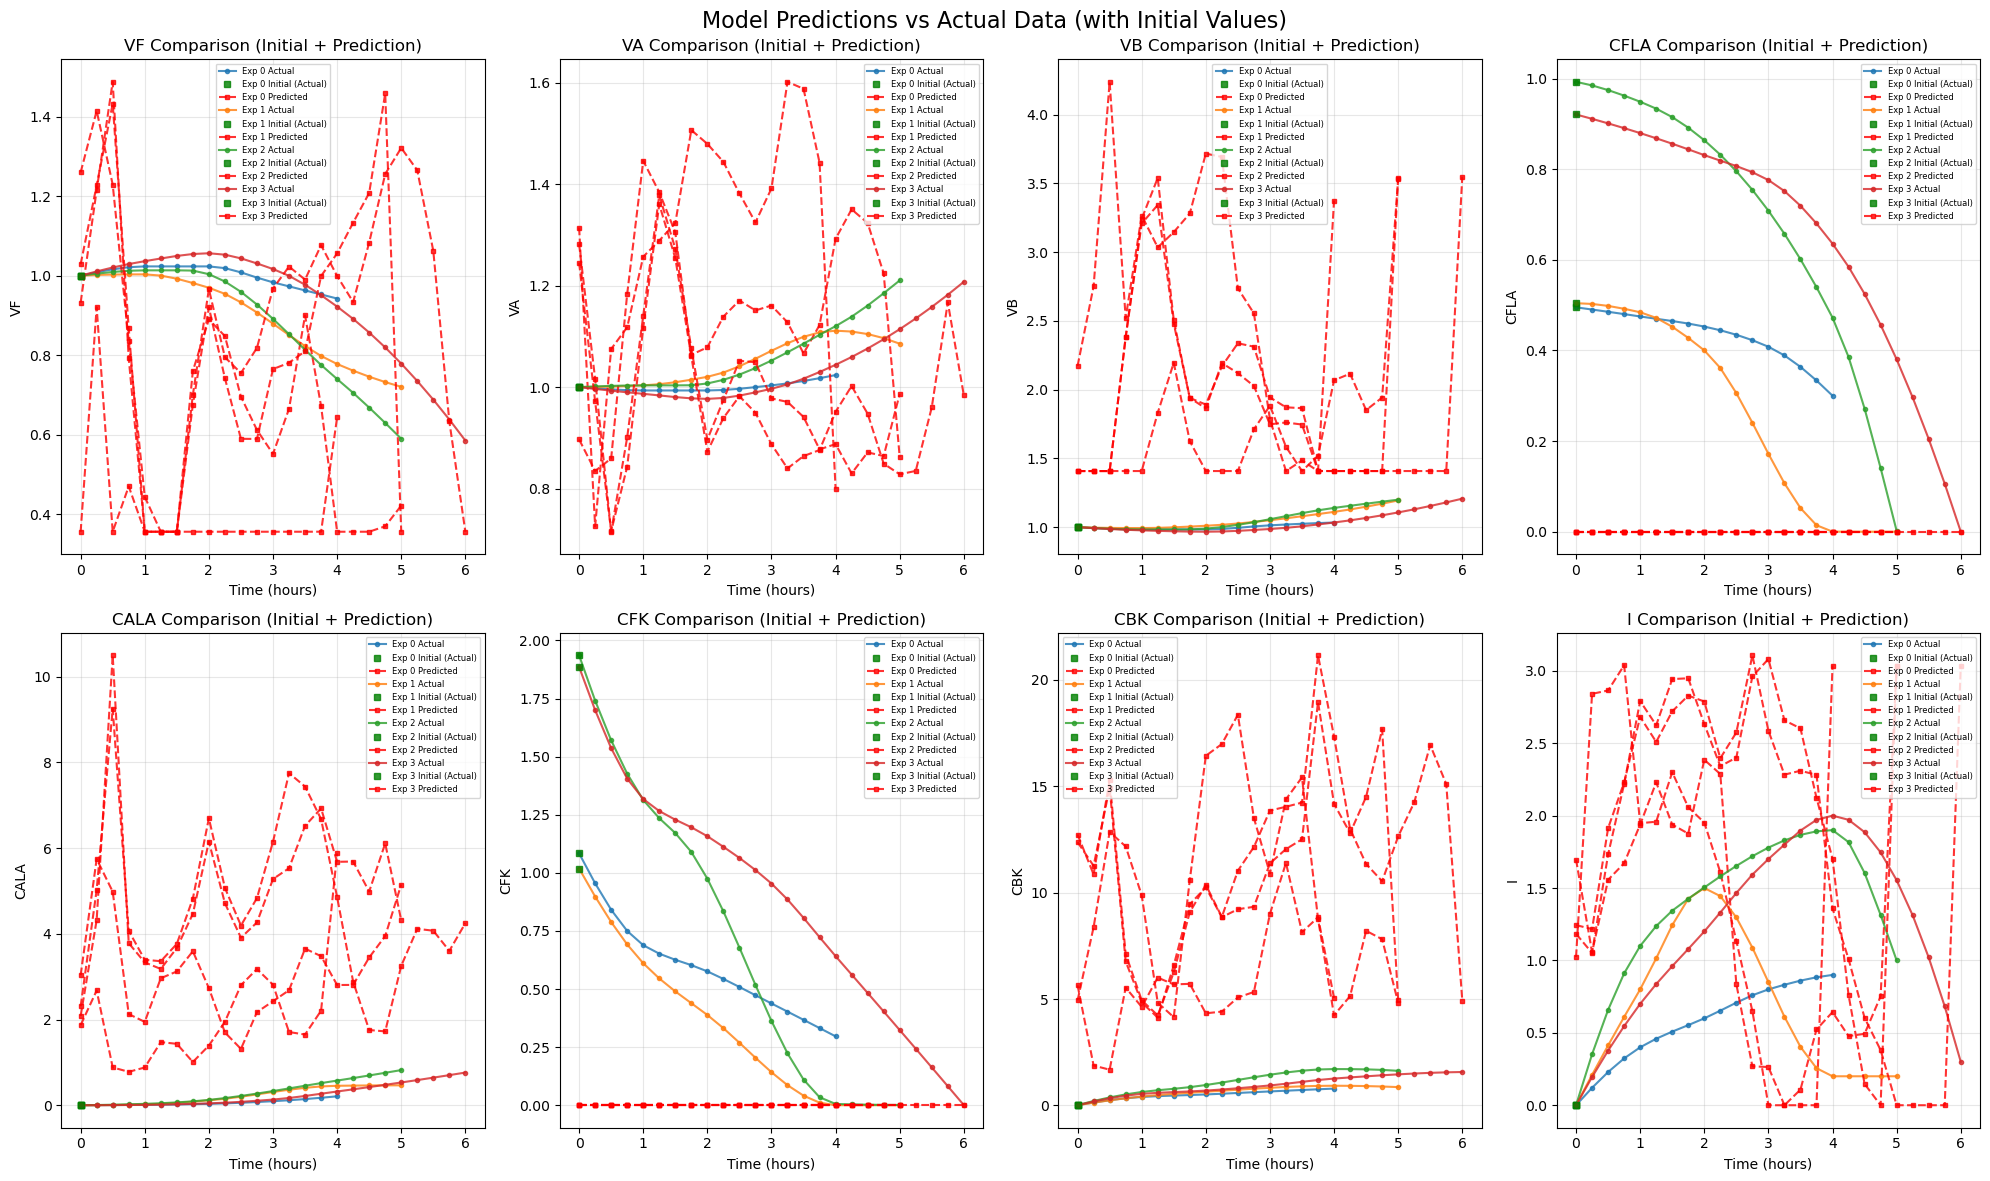


=== ÏàòÏ†ïÎêú ÏòàÏ∏° ÏãúÍ∞ÅÌôî ===
Ï¥àÍ∏∞Í∞í Î¨∏Ï†úÍ∞Ä Ìï¥Í≤∞Îêú Í∑∏ÎûòÌîÑÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§...

ÏàòÏ†ïÎêú Í∑∏ÎûòÌîÑ - Ïã§Ìóò 0...


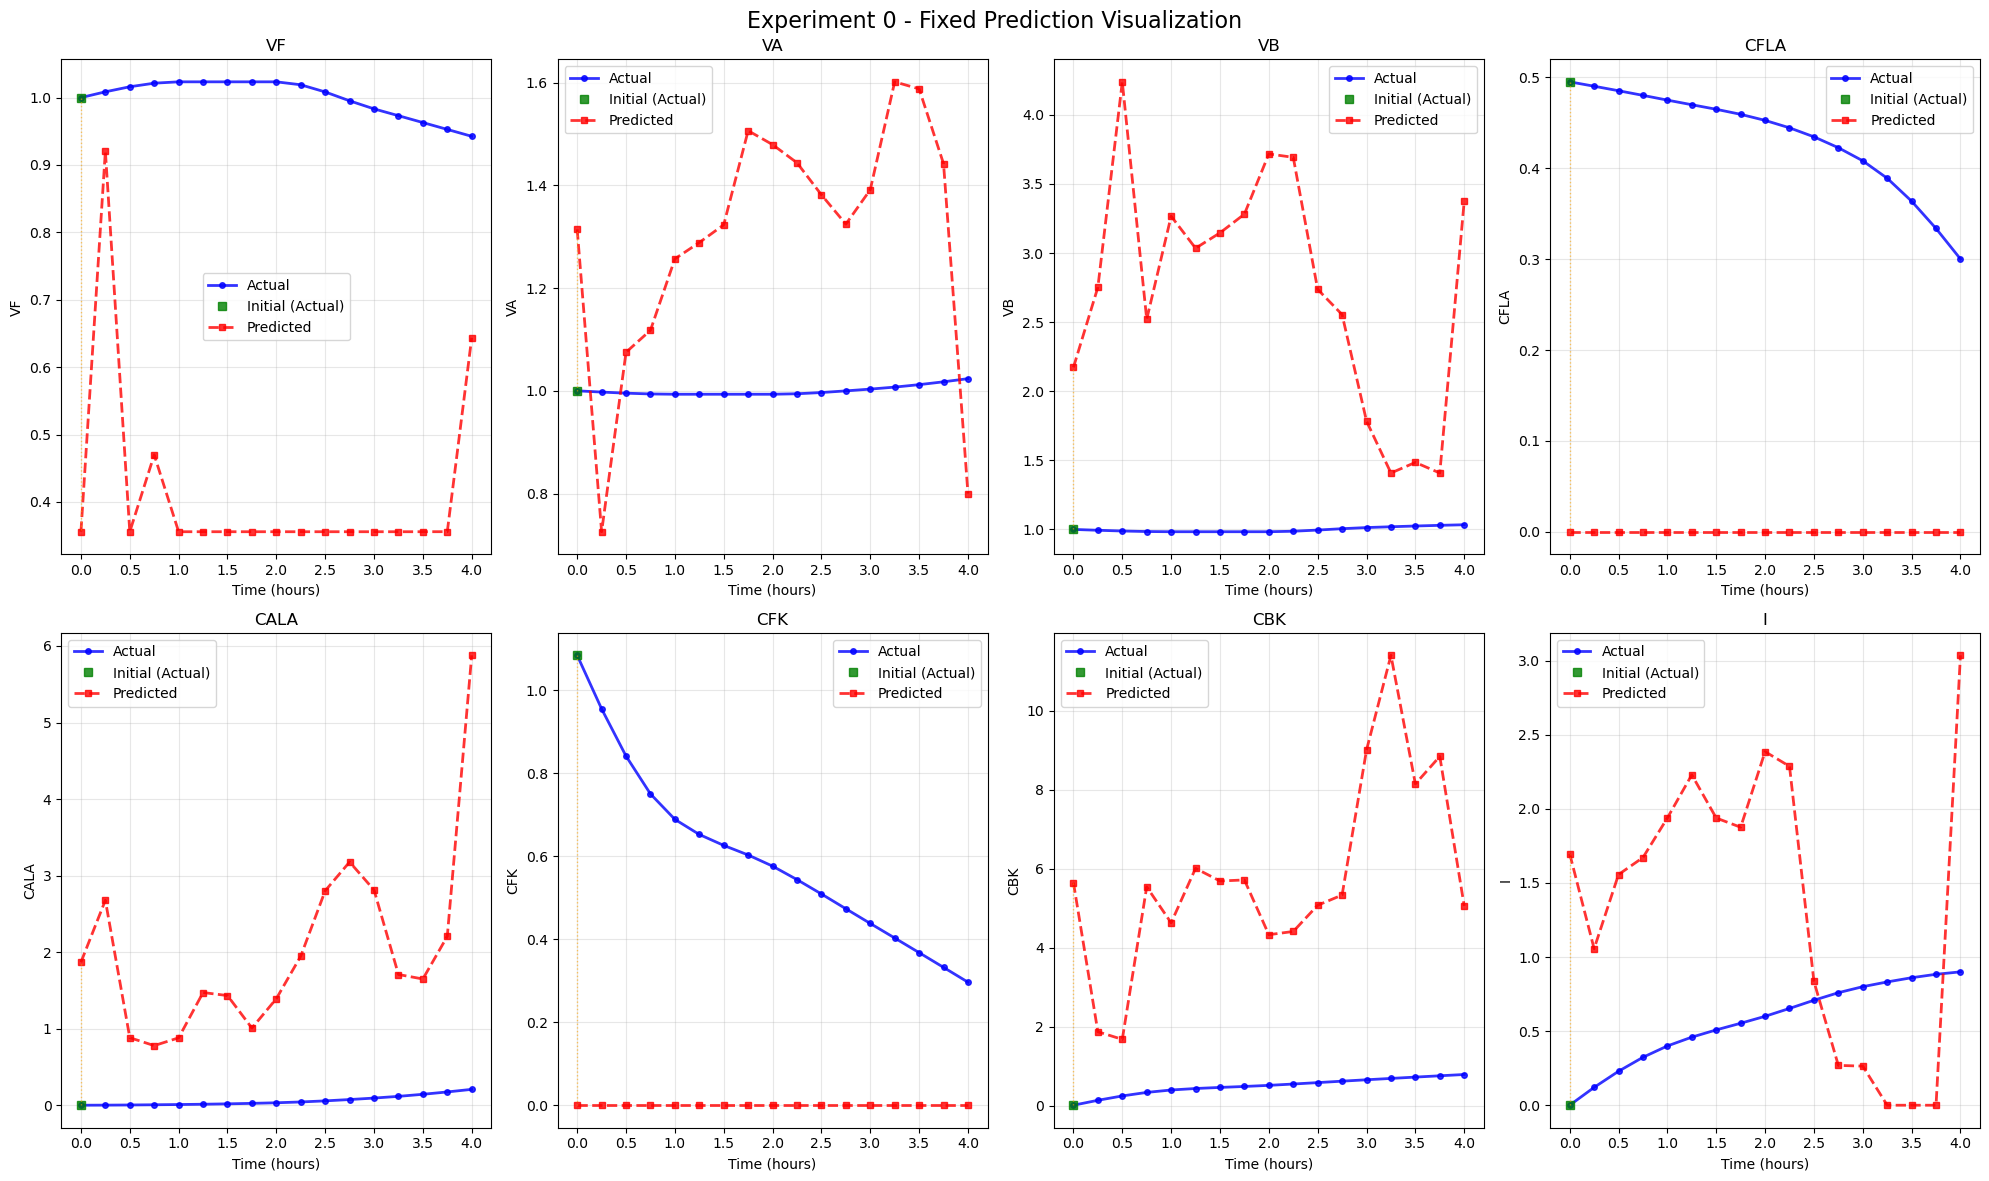


ÏàòÏ†ïÎêú Í∑∏ÎûòÌîÑ - Ïã§Ìóò 1...



ÏàòÏ†ïÎêú Í∑∏ÎûòÌîÑ - Ïã§Ìóò 2...


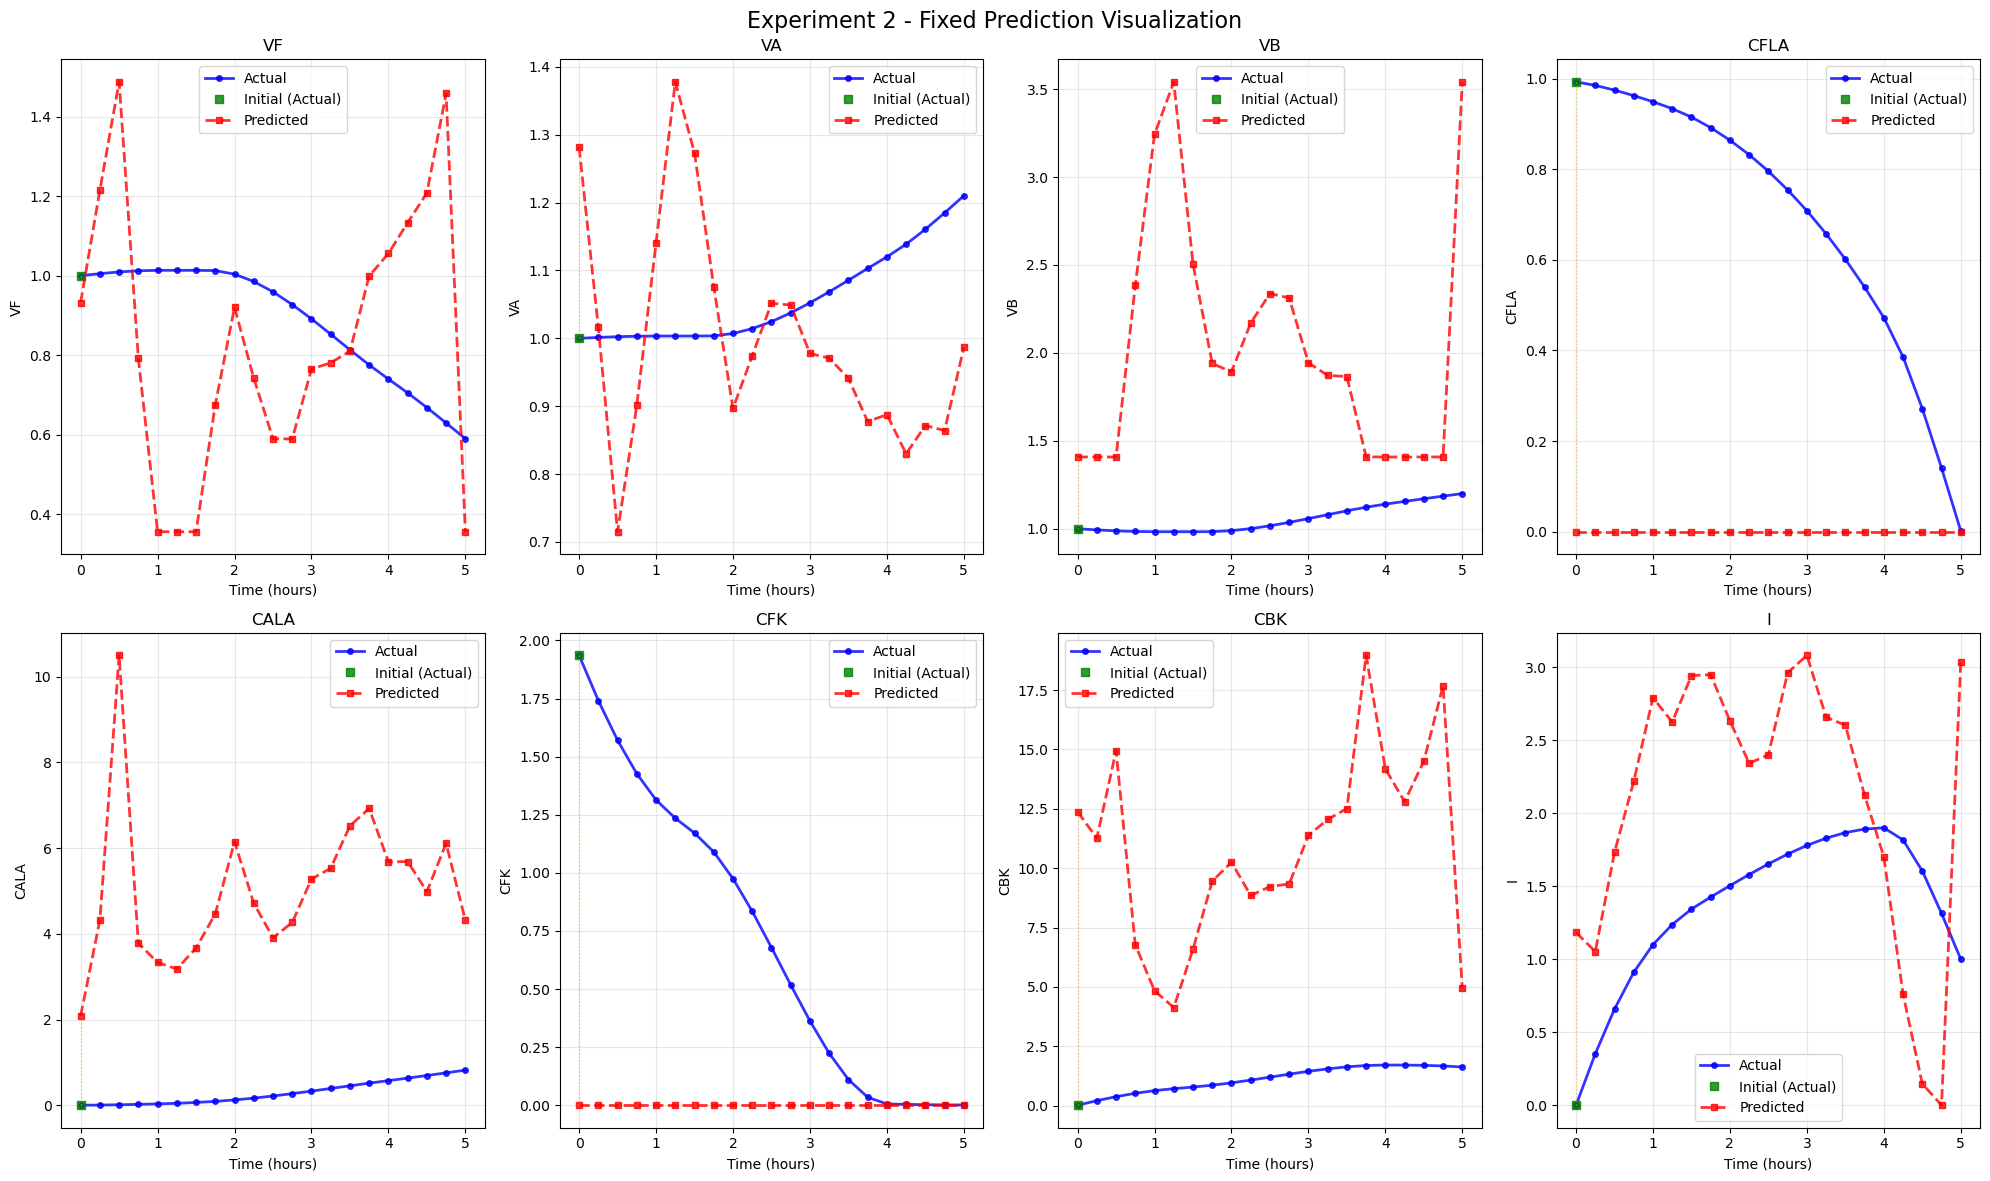


‚úÖ ÏàòÏ†ïÎêú Í∑∏ÎûòÌîÑ ÏôÑÎ£å!

=== Ìï¥Í≤∞Îêú Î¨∏Ï†úÏ†ê ===
1. Ï¥àÍ∏∞Í∞í(t=0)ÏùÑ Ïã§Ï†úÍ∞íÏúºÎ°ú ÌëúÏãú
2. ÏòàÏ∏°Í∞íÏùÄ t=0.25Î∂ÄÌÑ∞ ÏãúÏûëÌïòÎäî Í≤ÉÏùÑ Î™ÖÌôïÌûà Íµ¨Î∂Ñ
3. Ï¥àÍ∏∞Í∞íÏóêÏÑú Ï≤´ Î≤àÏß∏ ÏòàÏ∏°Í∞íÍπåÏßÄ Ïó∞Í≤∞ÏÑ† Ï∂îÍ∞Ä
4. ÏÉâÏÉÅÍ≥º ÎßàÏª§Î°ú Ïã§Ï†úÍ∞í, Ï¥àÍ∏∞Í∞í, ÏòàÏ∏°Í∞í Íµ¨Î∂Ñ


In [100]:
# Generate predictions and compare with actual data
import matplotlib.pyplot as plt

# Load pre-trained model first
print("Loading pre-trained model from best_bmed_noam_model.pth...")
try:
    model.load_state_dict(torch.load('best_bmed_noam_model.pth', map_location=device))
    model.eval()
    print("‚úì Pre-trained model loaded successfully!")
except FileNotFoundError:
    print("‚ùå Error: best_bmed_noam_model.pth not found in current directory")
    print("Please make sure the pre-trained model file exists.")
except Exception as e:
    print(f"‚ùå Error loading model: {str(e)}")

def predict_sequences(model, dataset, exp_num_list, device):
    """
    Generate predictions for all sequences in the dataset
    """
    model.eval()
    predictions = {}
    actual_data = {}
    
    with torch.no_grad():
        for idx, (input_seq, seq_length) in enumerate(dataset):
            exp_num = exp_num_list[idx]
            
            # Convert to tensors and move to device
            input_seq = input_seq.unsqueeze(0).to(device)  # Add batch dimension
            seq_length = seq_length.unsqueeze(0).to(device)
            print(input_seq)
            
            # Prepare input data (exclude current)
            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_length)
            
            # Generate predictions
            pred = model(inputs, target_seq_lengths)
            
            # Store results
            predictions[exp_num] = pred.cpu().numpy().squeeze()  # Remove batch dimension
            actual_data[exp_num] = targets.cpu().numpy().squeeze()
    
    return predictions, actual_data

# Load actual data for comparison
actual_df = pd.read_csv('BMED_DATA_AG.csv')

# Recreate range_mm for denormalization (same as used in norm_data)
range_mm = {
    'V': {'min': actual_df['V'].min() * 0.8, 'max': actual_df['V'].max() * 1.2},
    'E': {'min': actual_df['E'].min() * 0.8, 'max': actual_df['E'].max() * 1.2},
    'VF': {'min': actual_df['VF'].min() * 0.8, 'max': actual_df['VF'].max() * 1.2},
    'VA': {'min': actual_df['VA'].min() * 0.8, 'max': actual_df['VA'].max() * 1.2},
    'VB': {'min': actual_df['VB'].min() * 0.8, 'max': actual_df['VB'].max() * 1.2},
    'CFLA': {'min': 0, 'max': actual_df['CFLA'].max() * 1.2},
    'CALA': {'min': 0, 'max': actual_df['CALA'].max() * 1.2},
    'CFK': {'min': 0, 'max': actual_df['CFK'].max() * 1.2},
    'CBK': {'min': 0, 'max': actual_df['CBK'].max() * 1.2},
    'I': {'min': 0, 'max': actual_df['I'].max() * 1.2},
}

print("Generating predictions for all experiments...")
predictions, actual_normalized = predict_sequences(model, dataset, exp_num_list, device)

# Create subplots for each feature (2x4 grid) - ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for feat_idx, (feature_name, pred_idx) in enumerate(zip(feature_names, prediction_feature_indices)):
    ax = axes[feat_idx]
    
    # Show first 4 experiments to avoid overcrowding
    for exp_num in unique_exps[:4]:  
        # Get actual data for this experiment
        exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
        time_points = exp_actual['t'].values
        actual_values = exp_actual[feature_name].values
        
        # Get predicted data
        if exp_num in predictions:
            pred_normalized = predictions[exp_num]
            if len(pred_normalized.shape) > 1 and pred_idx < pred_normalized.shape[1]:
                pred_values = pred_normalized[:, pred_idx]
                
                # Denormalize predictions
                if feature_name in range_mm:
                    pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                                 range_mm[feature_name]['min'])
                
                # ÏàòÏ†ïÎêú ÏãúÍ∞Ñ Ï†ïÎ†¨: ÏòàÏ∏°Í∞íÏùÄ t=0.25Î∂ÄÌÑ∞ ÏãúÏûë
                pred_time = time_points[1:len(pred_values)+1] if len(pred_values) < len(time_points) else time_points[:len(pred_values)]
                
                # Ï¥àÍ∏∞Í∞í Ìè¨Ìï®Ìïú ÏôÑÏ†ÑÌïú ÏòàÏ∏° ÏãúÍ≥ÑÏó¥ ÏÉùÏÑ±
                # Ï≤´ Î≤àÏß∏ ÏãúÏ†ê(t=0)ÏùÄ Ïã§Ï†úÍ∞í ÏÇ¨Ïö©, ÎÇòÎ®∏ÏßÄÎäî ÏòàÏ∏°Í∞í
                full_pred_values = np.concatenate([actual_values[:1], pred_values[:len(pred_time)]])
                full_pred_time = np.concatenate([time_points[:1], pred_time])
                
                # Plot actual vs predicted
                ax.plot(time_points, actual_values, 'o-', label=f'Exp {exp_num} Actual', alpha=0.8, markersize=3, linewidth=1.5)
                
                # Ï¥àÍ∏∞Í∞í(Ïã§Ï†úÍ∞í)Í≥º ÏòàÏ∏°Í∞íÏùÑ Íµ¨Î∂ÑÌï¥ÏÑú ÌëúÏãú
                ax.plot(full_pred_time[:1], full_pred_values[:1], 's', label=f'Exp {exp_num} Initial (Actual)', 
                       alpha=0.8, markersize=5, color='green')
                ax.plot(pred_time, pred_values[:len(pred_time)], 's--', label=f'Exp {exp_num} Predicted', 
                       alpha=0.8, markersize=3, linewidth=1.5, color='red')
    
    ax.set_title(f'{feature_name} Comparison (Initial + Prediction)')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel(feature_name)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=6)

plt.suptitle('Model Predictions vs Actual Data (with Initial Values)', fontsize=16)
plt.tight_layout()
plt.show()

# Í∞úÎ≥Ñ Ïã§Ìóò ÎπÑÍµê Ìï®ÏàòÎèÑ ÏàòÏ†ï
def plot_experiment_comparison_fixed(exp_num, predictions, actual_df, range_mm, feature_names):
    """
    ÏàòÏ†ïÎêú Í∞úÎ≥Ñ Ïã§Ìóò ÎπÑÍµê ÌîåÎ°Ø - Ï¥àÍ∏∞Í∞í Î¨∏Ï†ú Ìï¥Í≤∞
    """
    if exp_num not in predictions:
        print(f"No predictions available for experiment {exp_num}")
        return
    
    # Get actual data for this experiment
    exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
    time_points = exp_actual['t'].values
    
    # Get predicted data
    pred_normalized = predictions[exp_num]
    
    # Create 2x4 subplot for this experiment
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    # Correct feature indices for predictions: [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I]
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # Skip V(0) and E(1)
    
    for feat_idx, feature_name in enumerate(feature_names):
        ax = axes[feat_idx]
        
        # Actual values
        actual_values = exp_actual[feature_name].values
        
        # Get predicted values with correct indexing
        if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
            pred_idx = prediction_indices[feat_idx]
            pred_values = pred_normalized[:, pred_idx]
            
            # Denormalize predictions
            if feature_name in range_mm:
                pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                             range_mm[feature_name]['min'])
            
            # ÏàòÏ†ïÎêú ÏãúÍ∞Ñ Ï†ïÎ†¨
            pred_time = time_points[1:len(pred_values)+1] if len(pred_values) < len(time_points) else time_points[:len(pred_values)]
            
            # Ï¥àÍ∏∞Í∞í Ìè¨Ìï®Ìïú ÏôÑÏ†ÑÌïú ÏòàÏ∏° ÏãúÍ≥ÑÏó¥ ÏÉùÏÑ±
            full_pred_values = np.concatenate([actual_values[:1], pred_values[:len(pred_time)]])
            full_pred_time = np.concatenate([time_points[:1], pred_time])
            
            # Plot
            ax.plot(time_points, actual_values, 'o-', label='Actual', color='blue', alpha=0.8, linewidth=2, markersize=4)
            
            # Ï¥àÍ∏∞Í∞íÍ≥º ÏòàÏ∏°Í∞í Íµ¨Î∂Ñ ÌëúÏãú
            ax.plot(full_pred_time[:1], full_pred_values[:1], 's', label='Initial (Actual)', 
                   color='green', alpha=0.8, markersize=6)
            ax.plot(pred_time, pred_values[:len(pred_time)], 's--', label='Predicted', 
                   color='red', alpha=0.8, linewidth=2, markersize=4)
            
            # Ïó∞Í≤∞ÏÑ† Ï∂îÍ∞Ä (Ï¥àÍ∏∞Í∞íÏóêÏÑú Ï≤´ Î≤àÏß∏ ÏòàÏ∏°Í∞íÍπåÏßÄ)
            if len(pred_time) > 0:
                ax.plot([time_points[0], pred_time[0]], [actual_values[0], pred_values[0]], 
                       ':', color='orange', alpha=0.6, linewidth=1)
            
            # Calculate and display error metrics (ÏòàÏ∏°Í∞íÎßå ÎπÑÍµê)
            if len(pred_values) <= len(actual_values) - 1:
                actual_subset = actual_values[1:len(pred_values)+1]
                if len(actual_subset) == len(pred_values[:len(actual_subset)]):
                    mse = np.mean((actual_subset - pred_values[:len(actual_subset)])**2)
                    rmse = np.sqrt(mse)
                    mae = np.mean(np.abs(actual_subset - pred_values[:len(actual_subset)]))
                    
                    # Calculate correlation
                    correlation = np.corrcoef(actual_subset, pred_values[:len(actual_subset)])[0, 1] if len(actual_subset) > 1 else 0
                    
                    ax.text(0.02, 0.98, f'RMSE: {rmse:.4f}\nMAE: {mae:.4f}\nCorr: {correlation:.3f}', 
                           transform=ax.transAxes, verticalalignment='top', 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No prediction data', transform=ax.transAxes, ha='center', va='center')
        
        ax.set_title(f'{feature_name}')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(feature_name)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle(f'Experiment {exp_num} - Fixed Prediction Visualization', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# ÏàòÏ†ïÎêú Ìï®ÏàòÎ°ú Îã§Ïãú ÌîåÎ°Ø
print("\n=== ÏàòÏ†ïÎêú ÏòàÏ∏° ÏãúÍ∞ÅÌôî ===")
print("Ï¥àÍ∏∞Í∞í Î¨∏Ï†úÍ∞Ä Ìï¥Í≤∞Îêú Í∑∏ÎûòÌîÑÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§...")

for exp_num in available_exps[:3]:  # Show first 3 available experiments
    print(f"\nÏàòÏ†ïÎêú Í∑∏ÎûòÌîÑ - Ïã§Ìóò {exp_num}...")
    plot_experiment_comparison_fixed(exp_num, predictions, actual_df, range_mm, feature_names)

print(f"\n‚úÖ ÏàòÏ†ïÎêú Í∑∏ÎûòÌîÑ ÏôÑÎ£å!")
print("\n=== Ìï¥Í≤∞Îêú Î¨∏Ï†úÏ†ê ===")
print("1. Ï¥àÍ∏∞Í∞í(t=0)ÏùÑ Ïã§Ï†úÍ∞íÏúºÎ°ú ÌëúÏãú")
print("2. ÏòàÏ∏°Í∞íÏùÄ t=0.25Î∂ÄÌÑ∞ ÏãúÏûëÌïòÎäî Í≤ÉÏùÑ Î™ÖÌôïÌûà Íµ¨Î∂Ñ")
print("3. Ï¥àÍ∏∞Í∞íÏóêÏÑú Ï≤´ Î≤àÏß∏ ÏòàÏ∏°Í∞íÍπåÏßÄ Ïó∞Í≤∞ÏÑ† Ï∂îÍ∞Ä")
print("4. ÏÉâÏÉÅÍ≥º ÎßàÏª§Î°ú Ïã§Ï†úÍ∞í, Ï¥àÍ∏∞Í∞í, ÏòàÏ∏°Í∞í Íµ¨Î∂Ñ")

Creating detailed comparison plots for individual experiments...
Available experiments for detailed plots: [0, 1, 2, 3, 4, 5]
\nPlotting detailed comparison for experiment 0...


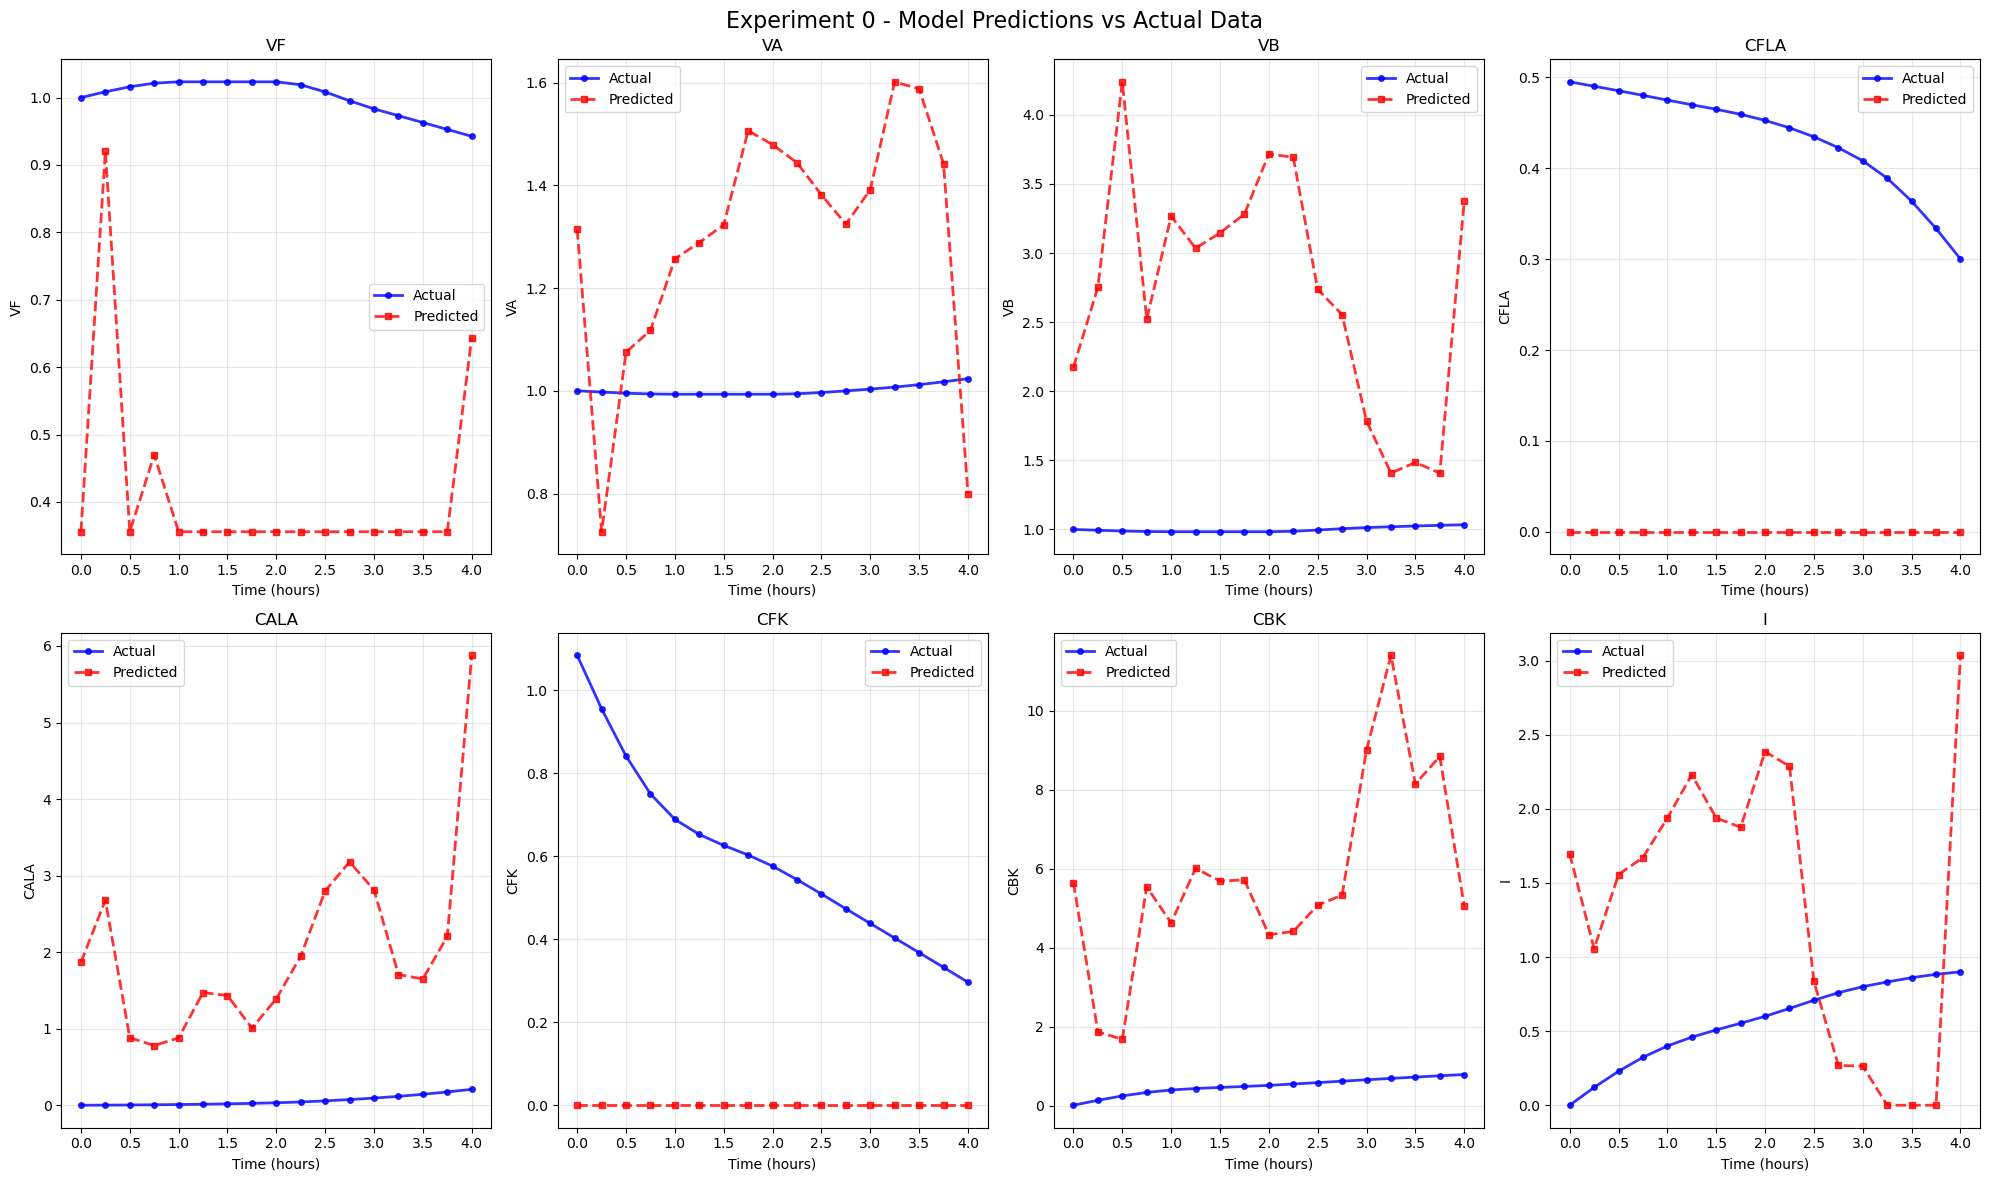

\nPlotting detailed comparison for experiment 1...


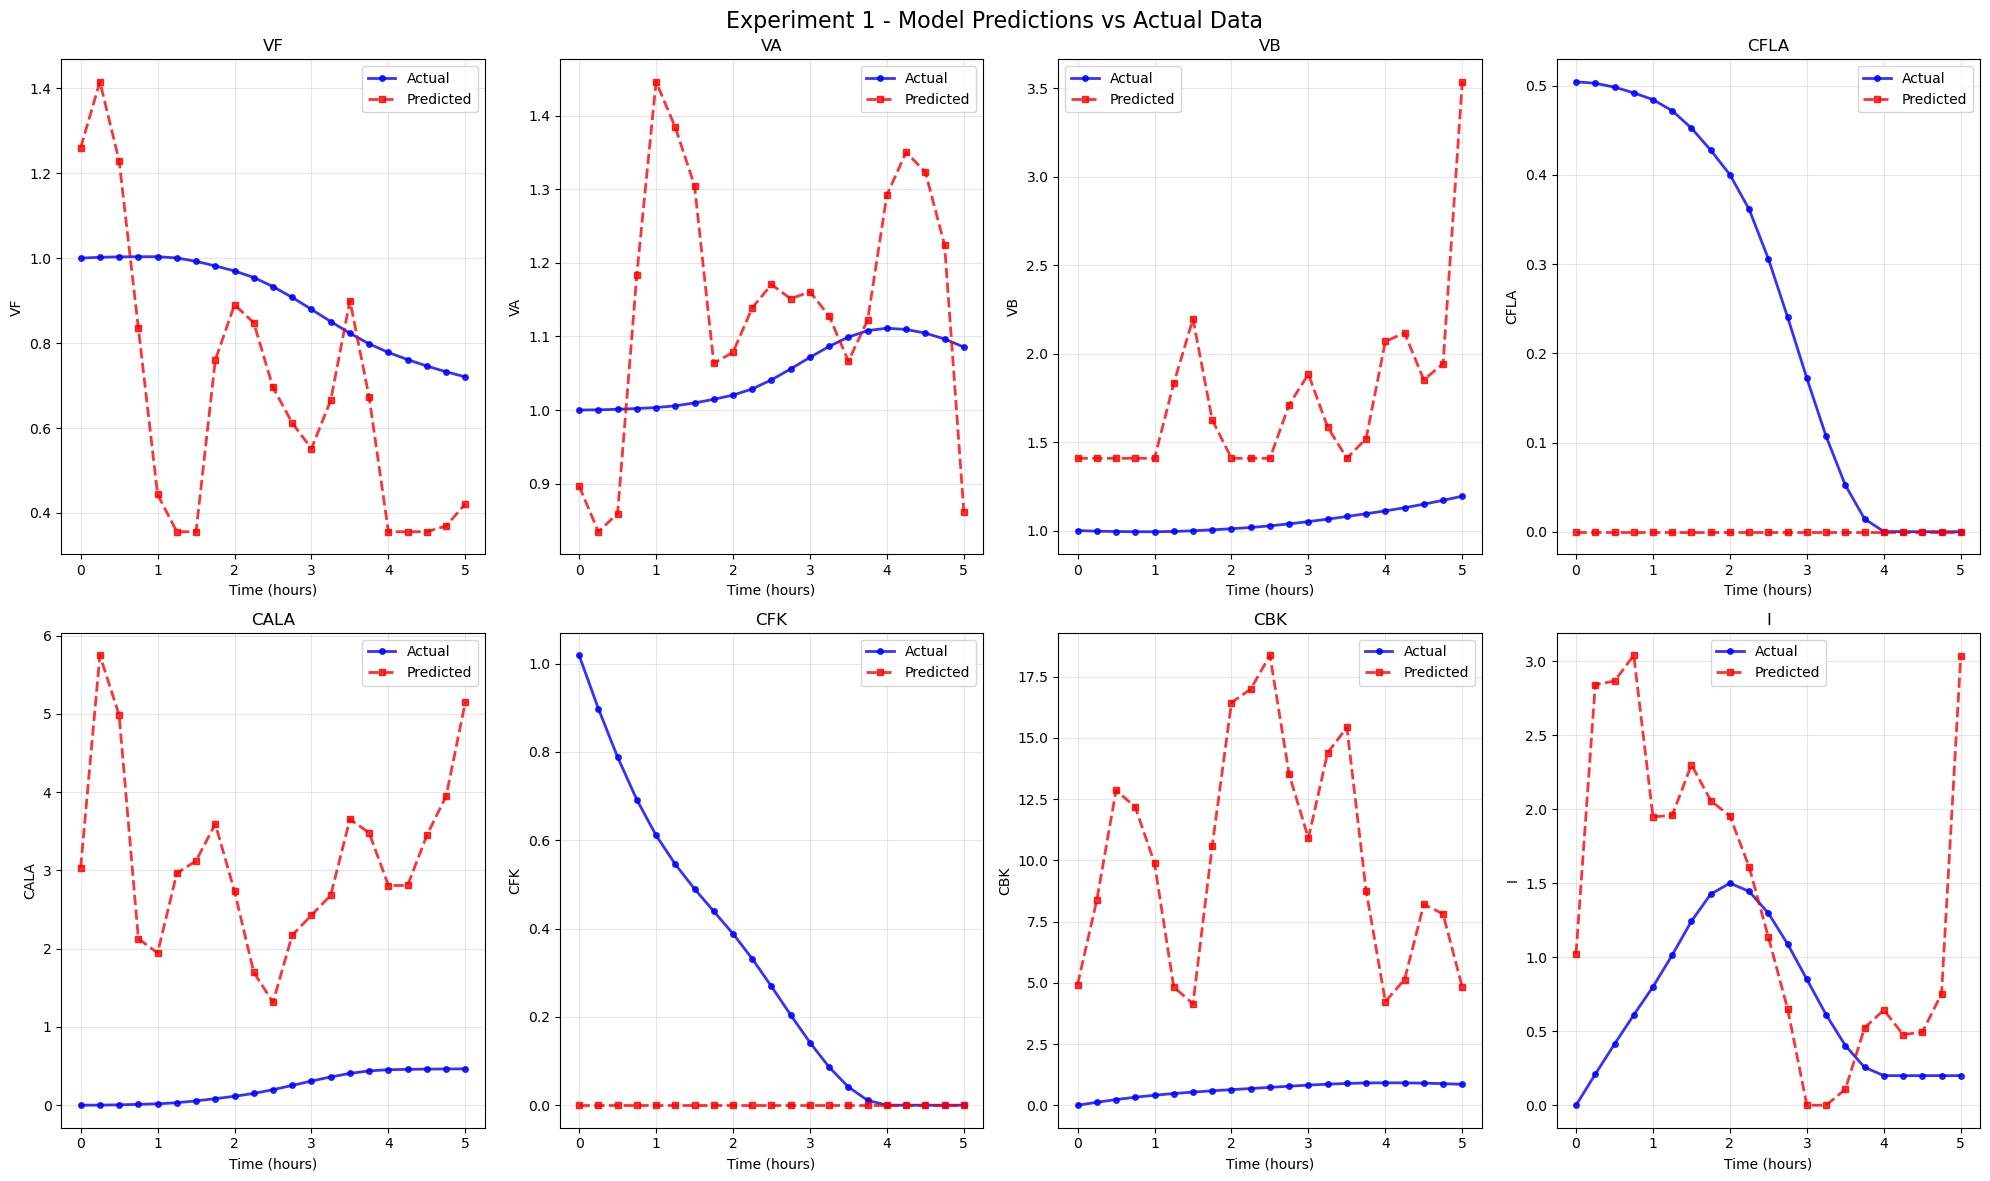

\nPlotting detailed comparison for experiment 2...


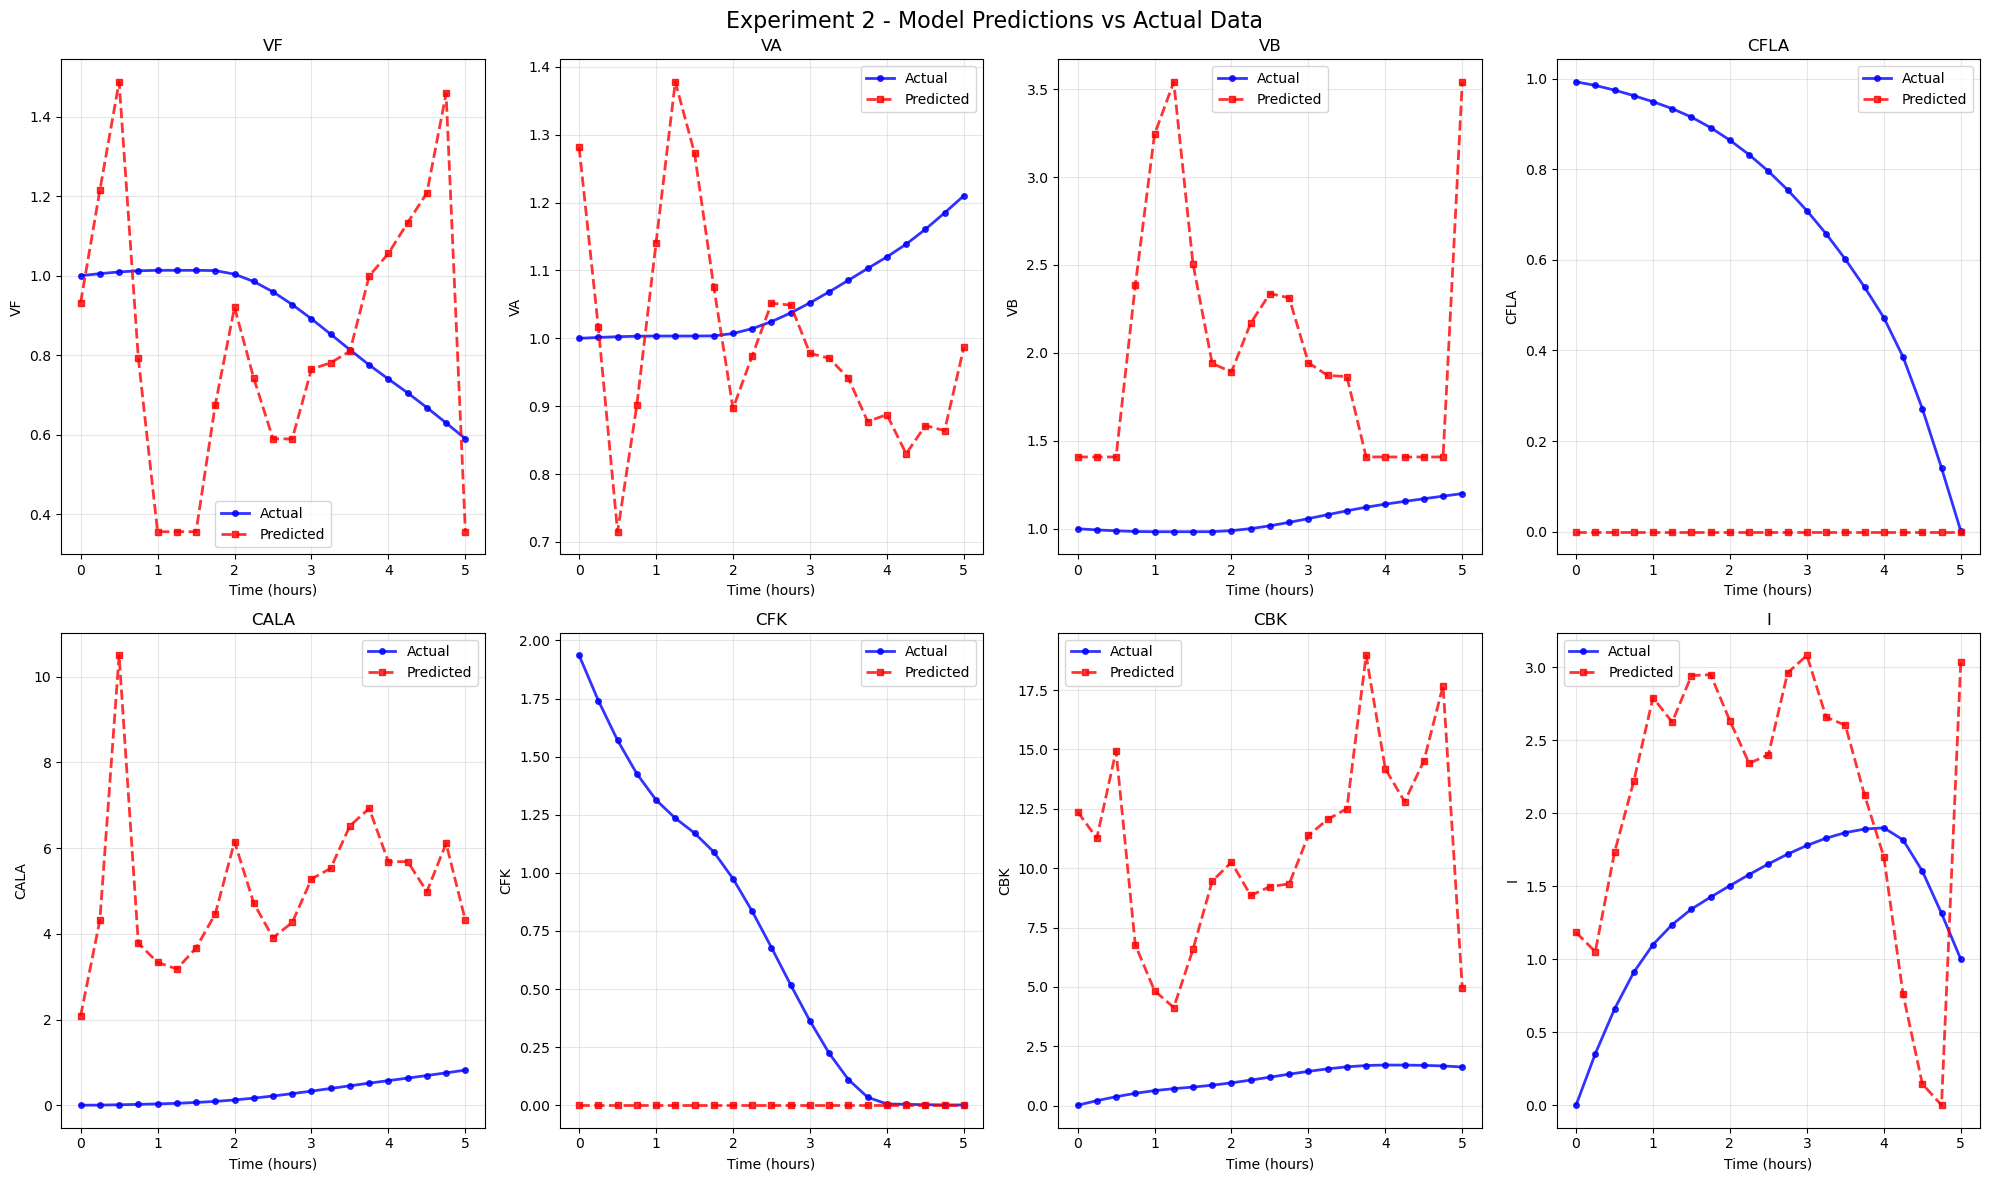

\n‚úÖ Completed detailed plotting for experiments: [0, 1, 2]
\n=== Debugging Information ===
Experiment 0 prediction shape: (32, 10)
  Sample time points: [0.   0.25 0.5 ]
  Sample VF actual: [1.         1.00859636 1.01609532]
  Sample VF predicted (normalized): [0.1       0.4403882 0.1      ]
Experiment 1 prediction shape: (32, 10)
  Sample time points: [0.   0.25 0.5 ]
  Sample VF actual: [1.         1.00193353 1.00292642]
  Sample VF predicted (normalized): [0.6449015 0.738397  0.6265391]
Experiment 2 prediction shape: (32, 10)
  Sample time points: [0.   0.25 0.5 ]
  Sample VF actual: [1.         1.00515203 1.00945946]
  Sample VF predicted (normalized): [0.44754836 0.6179135  0.78229636]


In [101]:
# Create individual experiment comparison plots with correct indexing
def plot_experiment_comparison(exp_num, predictions, actual_df, range_mm, feature_names):
    """
    Create subplot for a single experiment comparing all features with correct indexing
    """
    if exp_num not in predictions:
        print(f"No predictions available for experiment {exp_num}")
        return
    
    # Get actual data for this experiment
    exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
    time_points = exp_actual['t'].values
    
    # Get predicted data
    pred_normalized = predictions[exp_num]
    
    # Create 2x4 subplot for this experiment
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()
    
    # Correct feature indices for predictions: [V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I]
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # Skip V(0) and E(1)
    
    for feat_idx, feature_name in enumerate(feature_names):
        ax = axes[feat_idx]
        
        # Actual values
        actual_values = exp_actual[feature_name].values
        
        # Get predicted values with correct indexing
        if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
            pred_idx = prediction_indices[feat_idx]
            pred_values = pred_normalized[:, pred_idx]
            
            # Denormalize predictions
            if feature_name in range_mm:
                pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                             range_mm[feature_name]['min'])
            
            # Align time points (predictions start from t=0.25)
            pred_time = time_points[1:len(pred_values)+1] if len(pred_values) < len(time_points) else time_points[:len(pred_values)]
            
            # Plot
            ax.plot(time_points, actual_values, 'o-', label='Actual', color='blue', alpha=0.8, linewidth=2, markersize=4)
            ax.plot(pred_time, pred_values[:len(pred_time)], 's--', label='Predicted', color='red', alpha=0.8, linewidth=2, markersize=4)
            
            # Calculate and display error metrics
            if len(pred_values) <= len(actual_values) - 1:
                actual_subset = actual_values[1:len(pred_values)+1]
                if len(actual_subset) == len(pred_values[:len(actual_subset)]):
                    mse = np.mean((actual_subset - pred_values[:len(actual_subset)])**2)
                    rmse = np.sqrt(mse)
                    mae = np.mean(np.abs(actual_subset - pred_values[:len(actual_subset)]))
                    
                    # Calculate correlation
                    correlation = np.corrcoef(actual_subset, pred_values[:len(actual_subset)])[0, 1] if len(actual_subset) > 1 else 0
                    
                    ax.text(0.02, 0.98, f'RMSE: {rmse:.4f}\\nMAE: {mae:.4f}\\nCorr: {correlation:.3f}', 
                           transform=ax.transAxes, verticalalignment='top', 
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No prediction data', transform=ax.transAxes, ha='center', va='center')
        
        ax.set_title(f'{feature_name}')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(feature_name)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle(f'Experiment {exp_num} - Model Predictions vs Actual Data', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Plot comparisons for selected experiments
print("Creating detailed comparison plots for individual experiments...")

# Select experiments to show (first few available ones)
sample_experiments = [0, 1, 2, 3, 4, 5]
available_exps = [exp for exp in sample_experiments if exp in predictions]

print(f"Available experiments for detailed plots: {available_exps}")

for exp_num in available_exps[:3]:  # Show first 3 available experiments
    print(f"\\nPlotting detailed comparison for experiment {exp_num}...")
    plot_experiment_comparison(exp_num, predictions, actual_df, range_mm, feature_names)

print(f"\\n‚úÖ Completed detailed plotting for experiments: {available_exps[:3]}")

# Print prediction statistics for debugging
print(f"\\n=== Debugging Information ===")
for exp_num in available_exps[:3]:
    if exp_num in predictions:
        pred_shape = predictions[exp_num].shape
        print(f"Experiment {exp_num} prediction shape: {pred_shape}")
        
        # Show a sample of predictions vs actuals for first few time points
        exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
        print(f"  Sample time points: {exp_actual['t'].values[:3]}")
        print(f"  Sample VF actual: {exp_actual['VF'].values[:3]}")
        if len(predictions[exp_num].shape) > 1:
            print(f"  Sample VF predicted (normalized): {predictions[exp_num][:3, 2]}")  # VF is index 2

In [ ]:
# Model Evaluation: Feature-wise Analysis and Visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model_performance(predictions, actual_df, range_mm, feature_names):
    """
    Comprehensive model evaluation with feature-wise analysis
    """
    print("üîç MODEL PERFORMANCE EVALUATION")
    print("=" * 50)
    
    results = {}
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]  # Skip V(0) and E(1)
    
    # Collect all predictions and actuals for each feature
    for feat_idx, feature_name in enumerate(feature_names):
        all_actual = []
        all_predicted = []
        
        for exp_num in sorted(predictions.keys()):
            # Get actual data
            exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
            actual_values = exp_actual[feature_name].values
            
            # Get predicted data
            if exp_num in predictions:
                pred_normalized = predictions[exp_num]
                if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
                    pred_idx = prediction_indices[feat_idx]
                    pred_values = pred_normalized[:, pred_idx]
                    
                    # Denormalize predictions
                    if feature_name in range_mm:
                        pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                                     range_mm[feature_name]['min'])
                    
                    # Align data (skip first time point as it's used as input)
                    if len(pred_values) <= len(actual_values) - 1:
                        actual_subset = actual_values[1:len(pred_values)+1]
                        all_actual.extend(actual_subset)
                        all_predicted.extend(pred_values[:len(actual_subset)])
        
        # Calculate metrics
        if len(all_actual) > 0 and len(all_predicted) > 0:
            all_actual = np.array(all_actual)
            all_predicted = np.array(all_predicted)
            
            mse = mean_squared_error(all_actual, all_predicted)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(all_actual, all_predicted)
            r2 = r2_score(all_actual, all_predicted)
            
            # Calculate percentage errors
            mape = np.mean(np.abs((all_actual - all_predicted) / (all_actual + 1e-8))) * 100
            
            results[feature_name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R¬≤': r2,
                'MAPE': mape,
                'actual': all_actual,
                'predicted': all_predicted
            }
            
            print(f"{feature_name:8}: RMSE={rmse:.4f}, MAE={mae:.4f}, R¬≤={r2:.3f}, MAPE={mape:.1f}%")
    
    return results

def plot_feature_wise_analysis(results, feature_names):
    """
    Create comprehensive feature-wise plots
    """
    # 1. Performance metrics comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    metrics = ['RMSE', 'MAE', 'R¬≤', 'MAPE']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        values = [results[fname][metric] for fname in feature_names if fname in results]
        bars = ax.bar(feature_names[:len(values)], values, color=colors[i], alpha=0.7)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{val:.3f}' if metric != 'MAPE' else f'{val:.1f}%',
                   ha='center', va='bottom', fontsize=10)
        
        ax.set_title(f'{metric} by Feature')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Actual vs Predicted scatter plots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(feature_names):
        if feature_name in results:
            ax = axes[i]
            actual = results[feature_name]['actual']
            predicted = results[feature_name]['predicted']
            
            # Scatter plot
            ax.scatter(actual, predicted, alpha=0.6, s=20)
            
            # Perfect prediction line
            min_val = min(actual.min(), predicted.min())
            max_val = max(actual.max(), predicted.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Perfect Prediction')
            
            # R¬≤ and RMSE on plot
            r2 = results[feature_name]['R¬≤']
            rmse = results[feature_name]['RMSE']
            ax.text(0.05, 0.95, f'R¬≤ = {r2:.3f}\nRMSE = {rmse:.4f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel(f'Actual {feature_name}')
            ax.set_ylabel(f'Predicted {feature_name}')
            ax.set_title(f'{feature_name} Prediction Accuracy')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Residuals analysis
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(feature_names):
        if feature_name in results:
            ax = axes[i]
            actual = results[feature_name]['actual']
            predicted = results[feature_name]['predicted']
            residuals = actual - predicted
            
            # Residuals vs predicted
            ax.scatter(predicted, residuals, alpha=0.6, s=20)
            ax.axhline(y=0, color='r', linestyle='--', alpha=0.8)
            
            # Add mean and std of residuals
            mean_residual = np.mean(residuals)
            std_residual = np.std(residuals)
            ax.text(0.05, 0.95, f'Mean: {mean_residual:.4f}\nStd: {std_residual:.4f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel(f'Predicted {feature_name}')
            ax.set_ylabel('Residuals')
            ax.set_title(f'{feature_name} Residuals')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_time_series_by_feature(predictions, actual_df, range_mm, feature_names):
    """
    Plot time series for each feature across all experiments
    """
    prediction_indices = [2, 3, 4, 5, 6, 7, 8, 9]
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()
    
    for feat_idx, feature_name in enumerate(feature_names):
        ax = axes[feat_idx]
        
        # Plot each experiment
        for exp_num in sorted(list(predictions.keys())[:6]):  # First 6 experiments
            # Actual data
            exp_actual = actual_df[actual_df['exp'] == exp_num].sort_values('t')
            time_points = exp_actual['t'].values
            actual_values = exp_actual[feature_name].values
            
            # Predicted data
            if exp_num in predictions:
                pred_normalized = predictions[exp_num]
                if len(pred_normalized.shape) > 1 and feat_idx < len(prediction_indices):
                    pred_idx = prediction_indices[feat_idx]
                    pred_values = pred_normalized[:, pred_idx]
                    
                    # Denormalize
                    if feature_name in range_mm:
                        pred_values = (pred_values * (range_mm[feature_name]['max'] - range_mm[feature_name]['min']) + 
                                     range_mm[feature_name]['min'])
                    
                    pred_time = time_points[1:len(pred_values)+1]
                    
                    # Plot
                    ax.plot(time_points, actual_values, '-', alpha=0.7, linewidth=1.5, 
                           label=f'Exp {exp_num} Actual' if exp_num == sorted(list(predictions.keys()))[0] else '')
                    ax.plot(pred_time, pred_values[:len(pred_time)], '--', alpha=0.7, linewidth=1.5,
                           label=f'Exp {exp_num} Pred' if exp_num == sorted(list(predictions.keys()))[0] else '')
        
        ax.set_title(f'{feature_name} Time Series')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel(feature_name)
        ax.grid(True, alpha=0.3)
        if feat_idx == 0:
            ax.legend()
    
    plt.suptitle('Time Series Comparison: All Features Across Experiments', fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the evaluation
print("üöÄ Starting comprehensive model evaluation...")

# Evaluate model performance
performance_results = evaluate_model_performance(predictions, actual_df, range_mm, feature_names)

print(f"\nüìä Creating detailed visualizations...")

# Create comprehensive plots
plot_feature_wise_analysis(performance_results, feature_names)
plot_time_series_by_feature(predictions, actual_df, range_mm, feature_names)

print(f"\n‚úÖ Model evaluation completed!")
print(f"üìà Performance Summary:")
print(f"   - Total experiments evaluated: {len(predictions)}")
print(f"   - Features analyzed: {len(feature_names)}")
print(f"   - Best performing features (by R¬≤): ", end="")

# Find best features by R¬≤
if performance_results:
    best_features = sorted([(fname, results['R¬≤']) for fname, results in performance_results.items()], 
                          key=lambda x: x[1], reverse=True)[:3]
    print(", ".join([f"{fname} ({r2:.3f})" for fname, r2 in best_features]))